# Forward-kinematics

In [1]:
import math
import numpy as np
import control.matlab as control
import matplotlib.pyplot as plt
%matplotlib inline

def deg(theta):
    rad = (math.pi/180)*theta
    return rad

def cos(q):
    return math.cos(deg(q))

def sin(q):
    return math.sin(deg(q))

def atan(q1, q2):
    return (180/math.pi)*math.atan(q1/q2)

In [2]:
# Link Parameters:    [a, alpha, d, theta]
# For Multiple Links: [[a, alpha, d, theta]
#                      [a, alpha, d, theta]
#                      [a, alpha, d, theta]]

def atransformation(LinkParameters):
    a = LinkParameters[0]
    d = LinkParameters[2]
    alpha = LinkParameters[1]
    theta = LinkParameters[3]
    A = np.array([[[np.cos(theta), -np.sin(theta) * np.cos(alpha), np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
                   [np.sin(theta), np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
                   [0, np.sin(alpha), np.cos(alpha), d],
                   [0, 0, 0, 1]]])
    return (A)

def forward_kinematics_homogenous_matrix(DH):
    A = np.identity(4)
    n = np.shape(DH)[0]

    for i in range(n):
        Anext = atransformation(DH[i])
        A = np.matmul(A,Anext)

    return A

def end_effector_coordinates(DH):
  T= forward_kinematics_homogenous_matrix(DH)
  p=[T[0][0][3],T[0][1][3],T[0][2][3]]

  return p

# LinkParameters = [[0,0,l1,theta],
                  # [0,-np.pi/2,-(l3-d1),0],
                  # [0,0,l2+d2,0]]

# Example 1
# l1=70 l2=60 l3=85 theta=np.pi/4 d1=20 d2=20

LinkParameters1 = [[0,0,70,np.pi/4],
                  [0,-np.pi/2,-(85-20),0],
                  [0,0,60+20,0]]

P1 = end_effector_coordinates(LinkParameters1)
print("P1 =",P1)

# Example 2
# l1=70 l2=60 l3=85 theta=np.pi/3 d1=25 d2=15

LinkParameters2 = [[0,0,70,np.pi/3],
                  [0,-np.pi/2,-(85-25),0],
                  [0,0,60+15,0]]

P2 = end_effector_coordinates(LinkParameters2)

print("P2 =",P2)

# Example 3
# l1=70 l2=60 l3=85 theta=np.pi/7 d1=17 d2=35

LinkParameters3 = [[0,0,70,np.pi/7],
                  [0,-np.pi/2,-(85-17),0],
                  [0,0,60+35,0]]

P3 = end_effector_coordinates(LinkParameters3)

print("P3 =",P3)

P1 = [-56.5685424949238, 56.568542494923804, 5.000000000000005]
P2 = [-64.9519052838329, 37.50000000000001, 10.000000000000005]
P3 = [-41.21895521616802, 85.59204245072982, 2.0000000000000058]


# Inverse kinematics-velocity

In [3]:
def R_(ap, teta):
    R = np.array([[cos(teta), -sin(teta)*cos(ap),  sin(teta)*sin(ap)],
                  [sin(teta),  cos(teta)*cos(ap), -cos(teta)*sin(ap)],
                  [        0,            sin(ap),            cos(ap)]])
    return R
def P_(a, d, teta):
    P = np.array([[a*cos(teta)],
                  [a*sin(teta)],
                  [d]])
    return P

def inverse_velocity(n, s, DH, X_dot):
    To = np.identity(4, dtype = float)
    extra_row = np.array([0, 0, 0, 1])

    for i in range(n):
        a_i = DH[i][0]
        ap_i = DH[i][1]
        d_i = DH[i][2]
        teta_i = DH[i][3]

        R_i = R_(ap_i, teta_i)
        P_i = P_(a_i, d_i, teta_i)
        A_i = np.vstack((np.concatenate((R_i, P_i), axis=1), extra_row))
        To = np.dot(To, A_i)

    Pn = np.array([[To[0][3]],
                [To[1][3]],
                [To[2][3]]])


    T = np.identity(4, dtype = float)
    z = np.array([[0],
                [0],
                [1]])
    Pn = np.transpose(Pn)

    J = np.zeros([6,1])
    if s[0] == 'R':
        J0 = np.concatenate((np.cross(np.transpose(z), Pn), np.transpose(z)), axis=1)
    elif s[0] == 'P':
        J0 = np.concatenate((np.transpose(z), np.zeros([1,3])), axis=1)
    J = np.concatenate((J, np.transpose(J0)), axis=1)
    J = np.delete(J, 0, axis=1)

    for i in range(n-1):
        a_i = DH[i][0]
        ap_i = DH[i][1]
        d_i = DH[i][2]
        teta_i = DH[i][3]

        R_i = R_(ap_i, teta_i)
        P_i = P_(a_i, d_i, teta_i)
        A_i = np.vstack((np.concatenate((R_i, P_i), axis=1), extra_row))
        T = np.dot(T, A_i)
        R = T[:3,:3]
        P = np.transpose(T[:3,3])

        Z_i = np.transpose(np.dot(R, z))
        if s[i+1] == 'R':
            r1 = np.cross(Z_i, (Pn - P))
            r2 = Z_i
        elif s[i+1] == 'P':
            r1 = Z_i
            r2 = np.zeros([1,3])
        Ji = np.concatenate((r1, r2), axis = 1)
        Ji = np.transpose(Ji)
        J = np.concatenate((J, Ji), axis = 1)

    J_inv = np.linalg.pinv(J)
    q_dot = np.dot(J_inv, X_dot)
    print('q\u0307 =')
    print(q_dot)

# Inputs
n = 3                                     # Number of links
s = 'RPP'                                 # Type of joints
DH = np.array([[0, 0, 70, 45],            # DH Parameters (EACH ROW IN ORDER [ai, alpha_i, di, theta_i])
               [0, -90, -65, 0],           
               [0, 0, 80, 0]])
X_dot = np.array([[0], [10], [10], [0], [0], [25]])

inverse_velocity(n, s, DH, X_dot)


q̇ =
[[-0.0844689 ]
 [10.        ]
 [ 7.07106781]]


# Inverse Kinematics

In [4]:
def inverse_kinematics(x, y, z):
    theta = -atan(x,y)
    d1 = z - l1 + l3
    d2 = y/cos(theta) - l2

    return [theta, d1, d2]

    

# Inputs
(x, y, z) = (-41.21895521616802, 
             85.59204245072982, 
             2.0000000000000058)
l1 = 70
l2 = 60
l3 = 85

[theta, d1, d2] = inverse_kinematics(x, y, z)

print("\u03B8 = ", round(theta, 2), " deg.\n")
print("d1 = ", d1, " cm\n")
print("d2 = ", d2, " cm")

θ =  25.71  deg.

d1 =  17.0  cm

d2 =  35.0  cm


# Robot Dynamics

In [5]:
from sympy import *

l1=10
l2=10
d=10
m1=10
m2=10
m3=10
I1 = m1*(l1**2)/3
I2 = m2*(l2**2)/3

q1, q2, q3=symbols("q1 q2 q3")

J_vc1 = np.array([[(-l1/2)*sin(q1), 0, 0],[(l1/2)*cos(q1), 0, 0],[0, 0, 0]])
J_vc2 = np.array([[-l1*sin(q1)-(l2/2)*sin(q1+q2), (-l2/2)*sin(q1+q2), 0],[l1*cos(q1)+(l2/2)*cos(q1+q2), (l2/2)*cos(q1+q2), 0],[0, 0, 0]])
J_vc3 = np.array([[-l1*sin(q1)-l2*sin(q1+q2), l2*sin(q1+q2), 0],[l1*cos(q1)+l2*cos(q1+q2), l2*cos(q1+q2), 0],[0, 0, -1/2]])

d1=m1*np.matmul(np.transpose(J_vc1), J_vc1)
d2=m2*np.matmul(np.transpose(J_vc2), J_vc2)
d3=m3*np.matmul(np.transpose(J_vc3), J_vc3)

d_sum=np.add(np.add(d1,d2),d3)
I_sum=np.array([[I1+I2, I2, 0],[I2, I2, 0],[0, 0, 0]])
D_q= simplify(np.add(d_sum,I_sum))
print("D_q =",D_q,"\n")

q=np.array([q1,q2,q3])

c = [[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]]

# Calculating Christoffer Symbols
for k in range(0,3):
  for j in range(0,3):
    for i in range(0,3):
      c[i][j][k] = 0.5 * (diff(D_q[k][j], q[i]) + diff(D_q[k][i], q[j]) - diff(D_q[i][j], q[k]))
    
V_q = 13 * sin(q[0]) + 45 * (5 * sin(q[0]) + 3 * sin(q[0]))

Phi = [0] * 3
ct = 0
d=0
T = [0] * 3
q1d, q1dd, q2d, q2dd, q3d,q3dd = symbols("q1d q1dd q2d q2dd q3d q3dd")
qad = np.array([q1d, q2d, q3d])
qadd = np.array([q1dd, q2dd, q3dd])
for k in range(3): #corresponds to each link
      Phi[k] = diff(V_q, q[k])
      for j in range(3):
        d = d + D_q[k][j] * qadd[j] 
        for i in range(3):
          # print("i =",i,c[i][j][k])
          ct = ct + c[i][j][k] * qad[i] * qad[j]
          # print("ct =", ct)
      T[k] = d + ct + Phi[k]
      print("T(",k+1,") =",simplify(T[k]),"\n")

D_q = [[3000.0*cos(q2) + 4166.66666666667, 500.0*cos(q2) + 1000.0*cos(2*q1 + q2) + 1000.0*cos(2*q1 + 2*q2) + 583.333333333333, 0], [500.0*cos(q2) + 1000.0*cos(2*q1 + q2) + 1000.0*cos(2*q1 + 2*q2) + 583.333333333333, 1583.33333333333, 0], [0, 0, 2.5]] 

T( 1 ) = -3000.0*q1d*q2d*sin(q2) + q1dd*(3000.0*cos(q2) + 4166.66666666667) - q2d**2*(500.0*sin(q2) + 1000.0*sin(2*q1 + q2) + 2000.0*sin(2*q1 + 2*q2)) + q2dd*(500.0*cos(q2) + 1000.0*cos(2*q1 + q2) + 1000.0*cos(2*q1 + 2*q2) + 583.333333333333) + 373*cos(q1) 

T( 2 ) = 1500.0*q1d**2*sin(q2) - 2000.0*q1d**2*sin(2*q1 + q2) - 2000.0*q1d**2*sin(2*q1 + 2*q2) - 3000.0*q1d*q2d*sin(q2) + 3500.0*q1dd*cos(q2) + 1000.0*q1dd*cos(2*q1 + q2) + 1000.0*q1dd*cos(2*q1 + 2*q2) + 4750.0*q1dd - 500.0*q2d**2*sin(q2) - 1000.0*q2d**2*sin(2*q1 + q2) - 2000.0*q2d**2*sin(2*q1 + 2*q2) + 500.0*q2dd*cos(q2) + 1000.0*q2dd*cos(2*q1 + q2) + 1000.0*q2dd*cos(2*q1 + 2*q2) + 2166.66666666667*q2dd 

T( 3 ) = 1500.0*q1d**2*sin(q2) - 2000.0*q1d**2*sin(2*q1 + q2) - 2000.0*q1d**2*

# Independent joint control (PI control)

For link 1 

G = 
 
          64.25 s + 1.286
------------------------------------
0.07494 s^3 + s^2 + 2.525 s + 0.0505

For link 2 

G = 
 
      50.97 s + 0.51
---------------------------
0.03 s^3 + s^2 + 3 s + 0.03

For link 3 

G = 
 
       105 s + 1.05
---------------------------
0.05 s^3 + s^2 + 3 s + 0.03



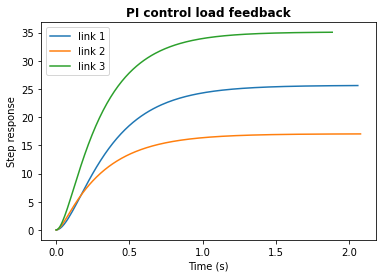

In [6]:
# Inputs
(x, y, z) = (-41.21895521616802, 
             85.59204245072982, 
             2.0000000000000058)
l1 = 70
l2 = 60
l3 = 85
# plt.figure(figsize=(10,5))
g = 9.81
def deg(theta):
    rad = (math.pi/180)*theta
    return rad
def cos(q):
    return math.cos(deg(q))
def sin(q):
    return math.sin(deg(q))
def atan(q1, q2):
    return (180/math.pi)*math.atan(q1/q2)
[theta, d1, d2] = inverse_kinematics(x, y, z)

# for Link 1

Jeff = 0.074945
Beff = 1
K = 1.01
Kp = 2.5
KI = 0.05
r = 0.00032
d = m1*g
s = symbols('s')
# ohmega_s = Jeff*s**3 + Beff*s**2 + K*Kp*s + K*KI
G = control.tf([Kp*theta-r*d, KI*theta], [Jeff, Beff, K*Kp, K*KI])
print("For link 1 \n")
print("G = \n", G)
# print(q_1_)
y,t = control.step(G)
plt.plot(t,y, label="link 1")
plt.xlabel('Time')
plt.title('Step Response')
# plt.plot(t, [q_1_ for i in t])

# for Link 2

Jeff = 0.03
Beff = 1
K = 1
Kp = 3
KI = 0.03
r = 0.00032
d = m2*g
s = symbols('s')
# ohmega_s = Jeff*s**3 + Beff*s**2 + K*Kp*s + K*KI
G = control.tf([Kp*d1-r*d, KI*d1], [Jeff, Beff, K*Kp, K*KI])
print("For link 2 \n")
print("G = \n", G)
# print(d_1)
y,t = control.step(G)
plt.plot(t,y, label="link 2")
plt.xlabel('Time')
plt.title('Step Response')
# plt.plot(t, [d_1 for i in t])

# for Link 3

Jeff = 0.05
Beff = 1
K = 1
Kp = 3
KI = 0.03
r = 0.00032
d = m2*g
s = symbols('s')
# ohmega_s = Jeff*s**3 + Beff*s**2 + K*Kp*s + K*KI
G = control.tf([Kp*d2-r*d, KI*d2], [Jeff, Beff, K*Kp, K*KI])
print("For link 3 \n")
print("G = \n", G)
# print(d_2)
y,t = control.step(G)
plt.plot(t,y, label="link 3")
plt.xlabel('Time (s)')
plt.ylabel('Step response')
plt.title('PI control load feedback', fontweight = 'bold')

# plt.plot(t, [d_2 for i in t])
# plt.grid(True)
plt.legend()
plt.show()